# Team Win/Loss Classifier

Classifies if an NBA home team won or lost a game.

In [408]:
import pandas as pd

nba_data = pd.read_csv('2023_nba_games_data')

# Raw dataset containing every game every NBA player in 2023.
# In later versions of the model, we can consider things like a player's 
# GmSc (a quantifier of how impactful a player was on the game) and classify if the home team will win or not based on
# average gmSc/minute of each player that will be starting. Thus, if Philadelphia has a great record but Joel Embiid is resting
# for the game, we may lean towards classifying Philadelphia as losing that home game.
nba_data.head(5)

,G,Date,Age,Tm,At,Opp,Point_Dif,GS,MP,FG,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player,Pos
0,1,2022-10-19,23-030,TOR,NaN,CLE,W (+3),0,17.9,4,...,0,0,0,0,1,10,5.0,-4.0,achiupr01,C
1,2,2022-10-21,23-032,TOR,@,BKN,L (-4),0,17.5,1,...,0,0,0,3,2,4,-2.2,-8.0,achiupr01,C
2,3,2022-10-22,23-033,TOR,@,MIA,L (-3),0,33.5,5,...,1,0,0,1,1,18,17.1,16.0,achiupr01,C
3,4,2022-10-24,23-035,TOR,@,MIA,W (+8),0,33.7,5,...,2,0,1,0,2,10,12.7,10.0,achiupr01,C
4,5,2022-10-26,23-037,TOR,NaN,PHI,W (+10),0,21.3,3,...,4,0,0,2,3,7,5.9,14.0,achiupr01,C


When calculating the early season win/loss ratios, we need the previous season's win/loss ratios to have a stronger weight due to the fact that there are not many prior games played early in the season. As the games increase, the team's previous season records will be less impactful.

In [402]:
# Gets last season's team records
last_season_records = pd.read_csv('2022_nba_team_records.csv')

def get_win_loss_ratio(record):
    wins = int(record.split('-')[0])
    losses = int(record.split('-')[1])
    return wins/(wins+losses)

last_season_records['W/L'] = last_season_records['Overall'].apply(get_win_loss_ratio)
last_season_records['W/L_Home'] = last_season_records['Home'].apply(get_win_loss_ratio)
last_season_records['W/L_Away'] = last_season_records['Road'].apply(get_win_loss_ratio)

abv_name_dict = {
    'Oklahoma City Thunder': 'OKC', 'Miami Heat': 'MIA', 'Los Angeles Clippers': 'LAC', 'San Antonio Spurs': 'SAS',
    'Denver Nuggets': 'DEN', 'New York Knicks': 'NYK', 'Memphis Grizzlies': 'MEM', 'Indiana Pacers': 'IND',
    'Houston Rockets': 'HOU', 'Brooklyn Nets': 'BKN', 'Los Angeles Lakers': 'LAL', 'Golden State Warriors': 'GSW',
    'Atlanta Hawks': 'ATL', 'Chicago Bulls': 'CHI', 'Utah Jazz': 'UTA', 'Boston Celtics': 'BOS',
    'Dallas Mavericks': 'DAL', 'Milwaukee Bucks': 'MIL', 'Toronto Raptors': 'TOR', 'Minnesota Timberwolves': 'MIN',
    'Washington Wizards': 'WAS', 'Portland Trail Blazers': 'POR', 'Philadelphia 76ers': 'PHI', 'Detroit Pistons': 'DET',
    'New Orleans Hornets': 'NOP', 'Cleveland Cavaliers': 'CLE', 'Charlotte Bobcats': 'CHA', 'New Orleans Pelicans': 'NOP',
    'Phoenix Suns': 'PHO', 'Sacramento Kings': 'SAC', 'Orlando Magic': 'ORL',  'Charlotte Hornets': 'CHA',
    'New Jersey Nets': 'BKN'
}

last_season_records['Tm'] = last_season_records['Tm'].apply(lambda team: abv_name_dict[team])

last_season_records = last_season_records[['Tm', 'W/L', 'W/L_Home', 'W/L_Away']]
last_season_records.head(5)

,Tm,W/L,W/L_Home,W/L_Away
0,PHO,0.780488,0.780488,0.780488
1,MEM,0.682927,0.731707,0.634146
2,GSW,0.646341,0.756098,0.536585
3,MIA,0.646341,0.707317,0.585366
4,DAL,0.634146,0.707317,0.560976


# Get team wins and losses

In [403]:
# Removes player-specific data.
nba_data = nba_data[['Date', 'Tm', 'At', 'Opp', 'Point_Dif']]

# Gets all the games played in the 2023 season
nba_data['Team1'] = nba_data.apply(lambda row: min(row['Tm'], row['Opp']), axis=1)
nba_data['Team2'] = nba_data.apply(lambda row: max(row['Tm'], row['Opp']), axis=1)
nba_data = nba_data.drop_duplicates(subset=['Date', 'Team1', 'Team2'])

# Drops those dummy columns so that our dataset would only have unique games. 
# That is, Bulls vs Heat on October 1st is redunant if we already have Heat vs Bulls on October 1st in the dataframe.
nba_data = nba_data.drop(['Team1', 'Team2'], axis=1)

def is_home_team_win(row):
    win_status = row['Point_Dif'].split(' ')[0]
    if row['At']=='@' and win_status=='L':
        return 1
    elif row['At']!='@' and win_status=='W':
        return 1
    elif row['At']=='@' and win_status=='W':
        return 0
    elif row['At']!='@' and win_status=='L':
        return 0

nba_data['Is_Home_Tm_Win'] = nba_data.apply(is_home_team_win, axis=1)
nba_data['Is_Away_Tm_Win'] = nba_data['Is_Home_Tm_Win'].apply(lambda x: 0 if x==1 else 1)

# In the next version of the model, we might want to consider using point differentials in the wins and losses.
nba_data['Home_Tm_Point_Dif'] = nba_data['Point_Dif'].apply(lambda x: x.split(" ")[1].replace('(','').replace(')','')).astype(int)*-1
nba_data['Away_Tm_Point_Dif'] = nba_data['Point_Dif'].apply(lambda x: x.split(" ")[1].replace('(','').replace(')','')).astype(int)

nba_data.head(5)

,Date,Tm,At,Opp,Point_Dif,Is_Home_Tm_Win,Is_Away_Tm_Win,Home_Tm_Point_Dif,Away_Tm_Point_Dif
0,2022-10-19,TOR,NaN,CLE,W (+3),1,0,-3,3
1,2022-10-21,TOR,@,BKN,L (-4),1,0,4,-4
2,2022-10-22,TOR,@,MIA,L (-3),1,0,3,-3
3,2022-10-24,TOR,@,MIA,W (+8),0,1,-8,8
4,2022-10-26,TOR,NaN,PHI,W (+10),1,0,-10,10


# Get each away team and home team's game number
For example, if GSW (home) is playing BKN (away) and GSW has played 2 games already and BKN has played 3 games already, this row should have a home_tm_gm_num of 3 and an away_tm_gm_num of 4.

In [404]:
# Initialize dictionaries to keep track of game numbers for each team
game_numbers_home = {}
game_numbers_away = {}

# Function to calculate the game number for each team
def calculate_game_number(row, game_numbers, is_away):
    team = row['Opp'] if is_away else row['Tm']
    if team in game_numbers:
        game_numbers[team] += 1
    else:
        game_numbers[team] = 1
    return game_numbers[team]

# Create columns for Away Team and Home Team
nba_data['Away_Tm'] = nba_data.apply(lambda row: row['Opp'] if row['At'] != '@' else row['Tm'], axis=1)
nba_data['Home_Tm'] = nba_data.apply(lambda row: row['Tm'] if row['At'] != '@' else row['Opp'], axis=1)

# Now that have the 'Home Team' and 'Away Team' columns, we can remove the 'Tm', 'At', and 'Opp' columns.
nba_data = nba_data.drop(['At', 'Tm', 'Opp', 'Point_Dif'], axis=1) 

def get_away_team_game_number(row):
    return len(nba_data[((nba_data['Away_Tm']==row['Away_Tm'])|(nba_data['Home_Tm']==row['Away_Tm']))&(nba_data['Date']<=row['Date'])])

def get_home_team_game_number(row):
    return len(nba_data[((nba_data['Away_Tm']==row['Home_Tm'])|(nba_data['Home_Tm']==row['Home_Tm']))&(nba_data['Date']<=row['Date'])])

nba_data['Away_Tm_Gm_Num'] = nba_data.apply(get_away_team_game_number, axis=1)
nba_data['Home_Tm_Gm_Num'] = nba_data.apply(get_home_team_game_number, axis=1)

nba_data.head(5)

,Date,Is_Home_Tm_Win,Is_Away_Tm_Win,Home_Tm_Point_Dif,Away_Tm_Point_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num
0,2022-10-19,1,0,-3,3,CLE,TOR,1,1
1,2022-10-21,1,0,4,-4,TOR,BKN,2,2
2,2022-10-22,1,0,3,-3,TOR,MIA,3,3
3,2022-10-24,0,1,-8,8,TOR,MIA,4,4
4,2022-10-26,1,0,-10,10,PHI,TOR,5,5


# Calculate each home team's current win/loss ratio at home and the away team's curent win/loss ratio on the road

In [405]:
# Gets the home team's win/loss ratio at home over the previous games
def home_tm_home_win_ratio_over_prev_gms(row):
    home_team = row['Home_Tm']
    home_game_num = row['Home_Tm_Gm_Num']

    home_mask = ((nba_data['Home_Tm']==home_team)&(nba_data['Home_Tm_Gm_Num']<row['Home_Tm_Gm_Num']))

    prev_gms = nba_data[home_mask]
    prev_home_wins = prev_gms[prev_gms['Home_Tm']==home_team]['Is_Home_Tm_Win'].sum()
    
    # For games early on in the season, there are not many prior games. Thus, the team's previous season's home win/loss ratio
    # is going to have a stronger influence early in the season.
    last_season_record = last_season_records[last_season_records['Tm']==home_team]['W/L_Home'].iloc[0]
    
    return (prev_home_wins+last_season_record)/(len(prev_gms)+1)

nba_data['Home_Tm_Home_W/L_Prev_Gms'] = nba_data.apply(home_tm_home_win_ratio_over_prev_gms, axis=1)

# Gets the away team's win/loss ratio on the road over the previous games
def away_tm_away_win_ratio_over_prev_gms(row):
    away_team = row['Away_Tm']
    away_game_num = row['Away_Tm_Gm_Num']

    away_mask = ((nba_data['Away_Tm']==away_team)&(nba_data['Away_Tm_Gm_Num']<row['Away_Tm_Gm_Num']))

    prev_gms = nba_data[away_mask]
    prev_away_wins = prev_gms[prev_gms['Away_Tm']==away_team]['Is_Away_Tm_Win'].sum()
    
    # For games early on in the season, there are not many prior games. Thus, the team's previous season's away win/loss ratio
    # is going to have a stronger influence early in the season.
    last_season_record = last_season_records[last_season_records['Tm']==away_team]['W/L_Away'].iloc[0]
    
    return (prev_away_wins+last_season_record)/(len(prev_gms)+1)

nba_data['Away_Tm_Away_W/L_Prev_Gms'] = nba_data.apply(away_tm_away_win_ratio_over_prev_gms, axis=1)

nba_data.head(5)

,Date,Is_Home_Tm_Win,Is_Away_Tm_Win,Home_Tm_Point_Dif,Away_Tm_Point_Dif,Away_Tm,Home_Tm,Away_Tm_Gm_Num,Home_Tm_Gm_Num,Home_Tm_Home_W/L_Prev_Gms,Away_Tm_Away_W/L_Prev_Gms
0,2022-10-19,1,0,-3,3,CLE,TOR,1,1,0.585366,0.463415
1,2022-10-21,1,0,4,-4,TOR,BKN,2,2,0.243902,0.585366
2,2022-10-22,1,0,3,-3,TOR,MIA,3,3,0.235772,0.292683
3,2022-10-24,0,1,-8,8,TOR,MIA,4,4,0.426829,0.195122
4,2022-10-26,1,0,-10,10,PHI,TOR,5,5,0.792683,0.329268


# Plot
To see if there are any patterns between the classes, a plot is useful.

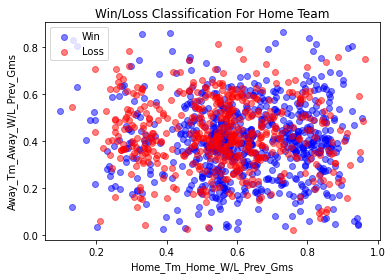

In [406]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = nba_data[['Home_Tm_Home_W/L_Prev_Gms', 'Away_Tm_Away_W/L_Prev_Gms']].values
y = nba_data['Is_Home_Tm_Win'].values

# Create scatter plot with transparency
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='b', alpha=0.5, label='Win')
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='r', alpha=0.5, label='Loss')

# Create and fit the model
model = LogisticRegression()
model.fit(X, y)

# Customize plot
plt.xlabel('Home_Tm_Home_W/L_Prev_Gms')
plt.ylabel('Away_Tm_Away_W/L_Prev_Gms')
plt.title('Win/Loss Classification For Home Team')
plt.legend(['Win', 'Loss'])

# Show plot
plt.show()

# Model and Classification Report
Because the data looks located in clusters, K-Nearest Neighbors seems like a good model. In our classification report and confusion matrix, we see it accurately classifies if the home team will win, but struggles with classifying if the away team will win

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        91
           1       0.72      0.72      0.72       155

    accuracy                           0.65       246
   macro avg       0.63      0.63      0.63       246
weighted avg       0.65      0.65      0.65       246


Confusion Matrix:
[[ 48  43]
 [ 43 112]]


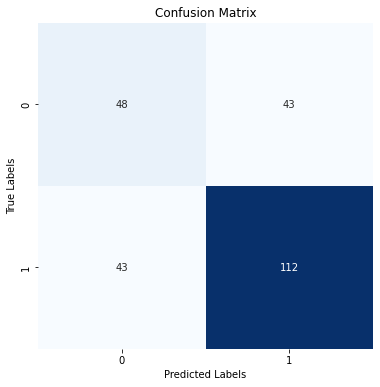

In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the features and target
X = nba_data[['Home_Tm_Home_W/L_Prev_Gms', 'Away_Tm_Away_W/L_Prev_Gms']]
y = nba_data['Is_Home_Tm_Win']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the KNN model
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Generate the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()